# MLFLOW - Deploying Machine Learning in Production (Assignment 10)

## Student: Rodolfo Lerma

In this assignment you will be writing a script that train models and use `mlflow` to submit runs. 

In [1]:
%%writefile ./new_data.json
{"age": {"0": 40, "1": 47},
 "balance": {"0": 580, "1": 3644},
 "campaign": {"0": 1, "1": 2},
 "contact": {"0": "unknown", "1": "unknown"},
 "day": {"0": 16, "1": 9},
 "default": {"0": "no", "1": "no"},
 "duration": {"0": 192, "1": 83},
 "education": {"0": "secondary", "1": "secondary"},
 "housing": {"0": "yes", "1": "no"},
 "job": {"0": "blue-collar", "1": "services"},
 "loan": {"0": "no", "1": "no"},
 "marital": {"0": "married", "1": "single"},
 "month": {"0": "may", "1": "jun"},
 "pdays": {"0": -1, "1": -1},
 "poutcome": {"0": "unknown", "1": "unknown"},
 "previous": {"0": 0, "1": 0}}

Overwriting ./new_data.json


In [2]:
#Load all necessary libraries
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
import joblib
import json

In [3]:
# Load Dataset
bank = pd.read_csv('bank-full.csv', delimiter = ';')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
bank.shape

(45211, 17)

The dataset has 17 columns & 45,211 rows.

In [5]:
bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
bank.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

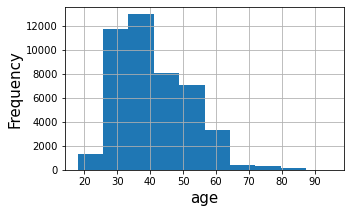

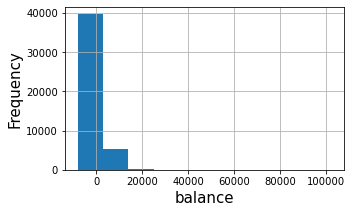

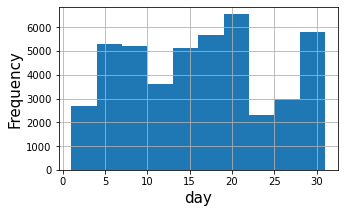

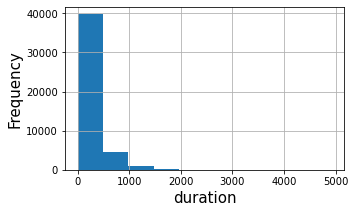

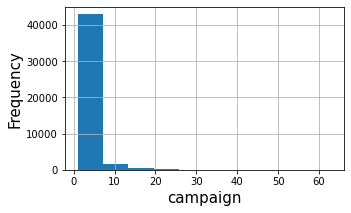

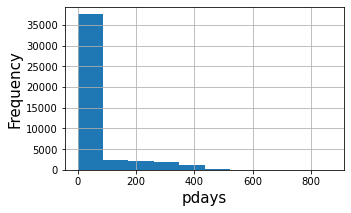

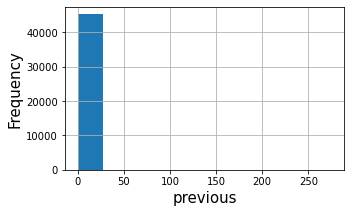

In [7]:
import matplotlib.pyplot as plt
numerical = ['age','balance','day','duration','campaign','pdays','previous']

def hist_plot(df,a):
    df[a].hist(figsize = (5,3))
    plt.xlabel(a, fontsize = 15)
    plt.ylabel('Frequency',fontsize = 15)
    plt.tick_params(axis="x", labelsize=10)
    plt.tick_params(axis="y", labelsize=10)
    plt.grid(True)
    plt.show()
    
for i in numerical:
    hist_plot(bank, i)

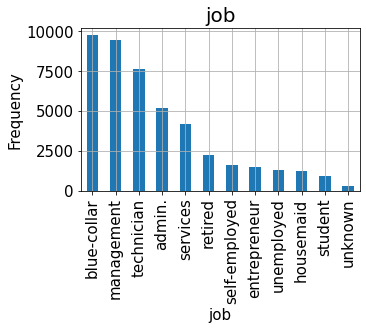

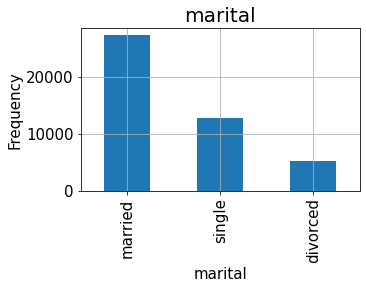

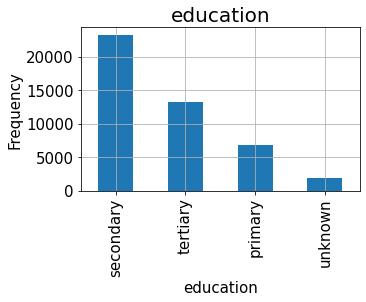

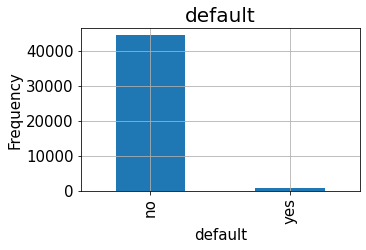

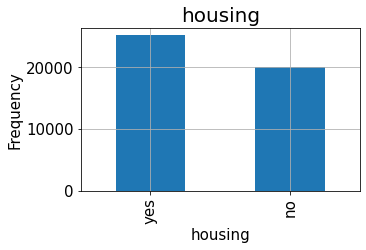

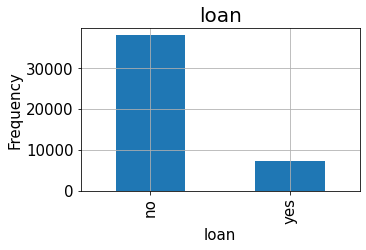

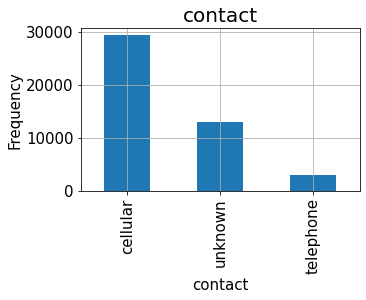

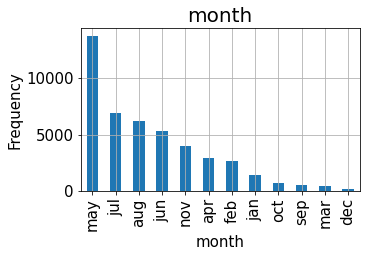

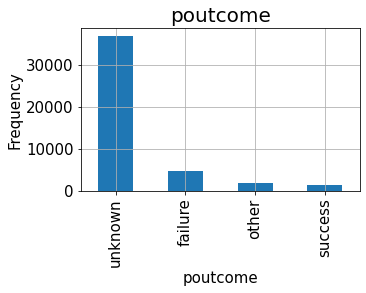

In [8]:
categorical = ['job','marital','education','default','housing','loan','contact','month', 'poutcome']
for i in categorical:
    bank.loc[:,i].value_counts().plot(kind='bar',figsize = (5,3))
    plt.xlabel(i, fontsize = 15)
    plt.ylabel('Frequency',fontsize = 15)
    plt.title(i, fontsize = 20)
    plt.tick_params(axis="x", labelsize=15)
    plt.tick_params(axis="y", labelsize=15)
    plt.grid(True)
    plt.show()

In [9]:
bank['y'] = bank['y'].replace({'no': 0, 'yes': 1})

In [10]:
# Split data between train and validation
X_train, X_test, y_train, y_test = train_test_split(bank.drop(columns = "y"), bank["y"], 
                                                    test_size = 0.10, random_state = 42)

X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

### Question 1: Create pre-processing function to be later used as part of the pipeline (custom transformer)

In [11]:
def transformations(df):
    onehoter = OneHotEncoder()
    cat_cols = df.select_dtypes(['object']).columns
    onehoter.fit(df[cat_cols])
    onehot_cols = onehoter.get_feature_names(cat_cols)
    df_onehot = pd.DataFrame(onehoter.transform(df[cat_cols]).toarray(), columns = onehot_cols)
   
    num_cols = df.select_dtypes(['integer', 'float']).columns
    znormalizer = StandardScaler()
    znormalizer.fit(df[num_cols])
    df_norm = pd.DataFrame(znormalizer.transform(df[num_cols]), columns = num_cols)

    df_featurized = df_onehot 
    df_featurized[num_cols] = df_norm 

    del df_onehot, df_norm
    return df_featurized

### Question 2: Creating a custom transformer from the previously defined function

In [12]:
pre_processing = FunctionTransformer(transformations, validate=False)

In [13]:
example = pre_processing.fit_transform(X_train)

### Question 3: Creating the pipeline and defining each of two steps: (i) pre-processing, and; (ii) model (Logistic)

In [14]:
pipeline = Pipeline(steps = [
                            ('preprocessor', pre_processing),
                            ('model', LogisticRegression())], 
                            verbose=True)

In [15]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'model', 'preprocessor__accept_sparse', 'preprocessor__check_inverse', 'preprocessor__func', 'preprocessor__inv_kw_args', 'preprocessor__inverse_func', 'preprocessor__kw_args', 'preprocessor__validate', 'model__C', 'model__class_weight', 'model__dual', 'model__fit_intercept', 'model__intercept_scaling', 'model__l1_ratio', 'model__max_iter', 'model__multi_class', 'model__n_jobs', 'model__penalty', 'model__random_state', 'model__solver', 'model__tol', 'model__verbose', 'model__warm_start'])

### Question 4: Call `fit` and `predict` on the pipeline to make sure that it all works. Remember to pass them the **un-processed** (original) data, since the data processing should be built into the pipeline now.

In [16]:
#Set parameters for Logistic Regression estimator ('model') inside the pipeline
pipeline.set_params(model__C = 0.8,                 # C: default=1.0
                    model__solver = 'saga',   # solver: {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
                    model__max_iter = 1000,         # max_iter: default=100
                    model__fit_intercept = True,   # fit_intercept:{True, False}, default=True
                    model__penalty = 'l2')         # penalty: {‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’ 
                                                 # Warning: The choice of the algorithm depends on the penalty chosen. 
                                                #          Not all algorithms support every type of penalty 
#Fit Training Data to Model
pipeline.fit(X_train, y_train)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.1s
[Pipeline] ............. (step 2 of 2) Processing model, total=  15.1s


Pipeline(steps=[('preprocessor',
                 FunctionTransformer(func=<function transformations at 0x00000273743CA4C0>)),
                ('model',
                 LogisticRegression(C=0.8, max_iter=1000, solver='saga'))],
         verbose=True)

In [17]:
#Prediction on Training and Test Data
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

### Question 5: Evaluate your model by calculating the precision and recall.

In [18]:
#Create a function to evaluate the model performance using precision and recall
def eval_metrics(actual, pred):
    precision = precision_score(actual, pred)
    recall = recall_score(actual, pred)
    return precision, recall

In [19]:
#Calculation of evaluation metrics - Precision and Recall for training and validation data
(precision_train, recall_train) = eval_metrics(y_train, y_train_pred)
(precision_test, recall_test) = eval_metrics(y_test, y_test_pred)

# Print Model (Logistic Regression) parameters
print()
print('Main Parameters used in logistic regression are: C={}, solver={}, max_iter={}, fit_intercept={} and penalty={}'.format(pipeline['model'].get_params()['C'],
                                                                                                                             pipeline['model'].get_params()['solver'],
                                                                                                                             pipeline['model'].get_params()['max_iter'],
                                                                                                                             pipeline['model'].get_params()['fit_intercept'],
                                                                                                                             pipeline['model'].get_params()['penalty']))
# Print Evaluation Metrics for the Model (Logistic Regression)
print()
print('Precision = {:.2f}% and recall = {:.2f}% on the training data.'.format(precision_train, recall_train))
print('Precision = {:.2f}% and recall = {:.2f}% on the validation data.'.format(precision_test, recall_test))


Main Parameters used in logistic regression are: C=0.8, solver=saga, max_iter=1000, fit_intercept=True and penalty=l2

Precision = 0.65% and recall = 0.35% on the training data.
Precision = 0.65% and recall = 0.34% on the validation data.


### Question 6: Save your pipeline object using `joblib` as shown [here](https://sklearn.org/modules/model_persistence.html).

In [20]:
#store 'pipeline' as pickle file using joblib
joblib.dump(pipeline, 'pipeline.joblib')

['pipeline.joblib']

### Question 7: Now write a **new script** for scoring: it loads the pipeline you saved in the last step, reads the data `../data/new_data.json` and converts it to a `pandas.DataFrame` object, and obtains predictions on it. The predictions should be stored as a `json` file `../data/new_preds.json`.

In [21]:
#Call and load stored 'pipeline' 
pipeline = joblib.load('pipeline.joblib')

#Read json file with new data and write into a pandas dataframe  
with open('./new_data.json', 'r') as f:
    data = json.load(f)
    
predictions = pd.DataFrame(data)
frames = [predictions, X_test]
df = pd.concat(frames)
new_predictions = df.reset_index()
new_predictions.drop(columns = 'index',inplace = True)

In [22]:
# #Use predict method of pipeline to score (make prediction) on new data 
new_predictions['prediction'] = pipeline.predict(new_predictions)
new_predictions = new_predictions.loc[:1]

In [23]:
#Write predictions of new data into a json file
new_predictions.to_json('./new_preds.json', orient='columns')

In [24]:
# Read json file containing predictions made for the new data and load them into a dataframe
with open('./new_preds.json', 'r') as f:
    data = json.load(f)
    
new_pred_dataframe= pd.DataFrame(data)

#Print predictions for each observation contained in the new_data.json file and the dataframe with the data and prediction
print(new_pred_dataframe['prediction'])
new_pred_dataframe

0    0
1    0
Name: prediction, dtype: int64


,age,balance,campaign,contact,day,default,duration,education,housing,job,loan,marital,month,pdays,poutcome,previous,prediction
0,40,580,1,unknown,16,no,192,secondary,yes,blue-collar,no,married,may,-1,unknown,0,0
1,47,3644,2,unknown,9,no,83,secondary,no,services,no,single,jun,-1,unknown,0,0


### Question 8: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. 
- What was your incoming experience with this model, if any? 
- what steps you took, what obstacles you encountered. 
- how you link this exercise to real-world, machine learning problem-solving.
- What steps were missing? What else do you need to learn?

https://github.com/milindparvatia/ML-Project

https://github.com/dzubii/Machine-Learning-Project/blob/master/EDA_and_Modeling_FINAL.ipynb

https://github.com/dzubii/Machine-Learning-Project/blob/master/MLProject_Bank.ipynb